In [2]:
# Preprocessing
import pandas as pd
import tables
import time
import numpy as np
import gc
from tqdm import tqdm_notebook
from data_processing_xu import get_data_2dprojection
import os

In [57]:
%run data_processing_xu.py

In [52]:
#DATA_DIR = '/storage/home/vprov/JUNO/JUNO_students/data/'
#TRAIN_DIR = '/srv/hd5/data/vprov/data/phase_1/train/'
TRAIN_DIR = '~/data/data_dir/'
tr_lpmt_hits = pd.read_hdf(TRAIN_DIR + 'lpmt_hits.h5', mode='r') 
tr_spmt_hits = pd.read_hdf(TRAIN_DIR + 'spmt_hits.h5', mode='r')
tr_pos = pd.read_csv(TRAIN_DIR + 'lpmt_pos.csv') 
tr_spmt_pos = pd.read_csv(TRAIN_DIR + 'spmt_pos.csv') 
tr_true_info = pd.read_csv(TRAIN_DIR + 'true_info.csv')

In [3]:
rg = np.arange(0,100000,15000)

In [59]:
LTRAIN = '/mnt/iprovilkov/data_dir/npdata/'

In [62]:
MAXR=17200

In [63]:
for start, end  in zip(rg[:-1], rg[1:]):
    data_lpmt, event_to_id = get_data_2dprojection(tr_lpmt_hits[(tr_lpmt_hits['event'] >= start) & (tr_lpmt_hits['event'] < end)
                                                                & (tr_lpmt_hits['isDN'] == False)], 
                                                tr_spmt_hits[(tr_spmt_hits['event'] >= start) & (tr_spmt_hits['event'] < end) 
                                                            & (tr_spmt_hits['isDN'] == False)], 
                                                tr_pos, 
                                                tr_true_info[(tr_true_info.R<=MAXR) 
                                                             & (tr_true_info['evtID'] >= start) 
                                                             & (tr_true_info['evtID'] < end)],
                                                use_spmt=False,
                                                time='tomax')
    np.save(LTRAIN + '1_' + str(start) + 'without_noise' + '_time_min_xu_l', data_lpmt)

Make projection
Starting cycle...



Make projection
Starting cycle...



Make projection
Starting cycle...



Make projection
Starting cycle...



Make projection
Starting cycle...



Make projection
Starting cycle...


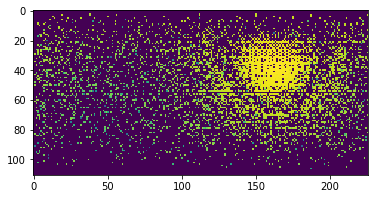

In [64]:
import matplotlib.pyplot as plt
plt.imshow(data_lpmt[0][:,:,1])

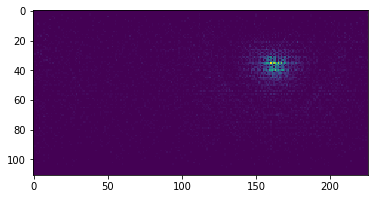

In [65]:
plt.imshow(data_lpmt[0][:,:,0])

In [11]:
data_lpmt[0][:,:,1].max()

8.63623740196228

In [66]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [67]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [68]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [92]:
import keras
import keras.layers as L
from keras.models import Sequential

In [113]:
model = Sequential()
model.add(L.Conv2D(filters=32, kernel_size=(3,3),activation='relu', strides=(1,1)))
model.add(L.MaxPool2D(strides=(2,2)))
model.add(L.Conv2D(filters=64, kernel_size=(3,3),activation='relu', strides=(1,1)))
model.add(L.MaxPool2D(strides=(2,2)))
model.add(L.Conv2D(filters=64, kernel_size=(3,3),activation='relu', strides=(1,1)))
model.add(L.MaxPool2D(strides=(2,2)))
model.add(L.Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(L.Flatten())
model.add(L.Dense(256, activation='relu'))
model.add(L.Dense(256, activation='relu'))
model.add(L.Dense(1))

In [114]:
from keras.optimizers import Adam

In [115]:
opt = Adam(decay=1e-4)

In [116]:
model.compile(loss='mean_squared_error', optimizer=opt)

In [117]:
model.build(input_shape=(None, 111,226,2))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 109, 224, 32)      608       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 54, 112, 32)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 52, 110, 64)       18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 26, 55, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 24, 53, 64)        36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 12, 26, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 10, 24, 128)       73856     
__________

In [6]:
logdir = 'log_YuXu_tomax.csv'

In [119]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger(logdir, append=True, separator=';')

In [120]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001)

In [121]:
epochs = [5,5,5,5,1,1,1]

In [ ]:
import gc
for i in range(7):
    for start, end in zip(rg[:-1], rg[1:]):
        data_lpmt = np.load(LTRAIN + '1_' + str(start) +'without_noise_time_min_xu_l'+ '.npy')
        ys = tr_true_info[(tr_true_info['evtID'] >= start) 
                            & (tr_true_info['evtID'] < end)]
        mask = (ys.R <= MAXR)
        data_lpmt = data_lpmt[mask]
        y_val = ys[mask][['E']].values
        
        X_train, X_test, y_train, y_test = train_test_split(data_lpmt, y_val, test_size=0.2, random_state=45)
        out = model.fit(X_train, y_train, batch_size=32, 
                epochs=epochs[i],
                callbacks=[csv_logger, reduce_lr],
                validation_data=(X_test, y_test),
                shuffle=True)
    gc.collect()

Train on 11020 samples, validate on 2756 samples
Epoch 1/5
11020/11020 [==============================] - 28s 3ms/step - loss: 2.0992 - val_loss: 0.7883
Epoch 2/5
11020/11020 [==============================] - 25s 2ms/step - loss: 0.5882 - val_loss: 0.3015
Epoch 3/5
11020/11020 [==============================] - 25s 2ms/step - loss: 0.2664 - val_loss: 0.3087
Epoch 4/5
11020/11020 [==============================] - 24s 2ms/step - loss: 0.2535 - val_loss: 0.4048
Epoch 5/5
11020/11020 [==============================] - 25s 2ms/step - loss: 0.1475 - val_loss: 0.1029
Train on 10988 samples, validate on 2747 samples
Epoch 1/5
10988/10988 [==============================] - 25s 2ms/step - loss: 0.1384 - val_loss: 0.2373
Epoch 2/5
10988/10988 [==============================] - 24s 2ms/step - loss: 0.1075 - val_loss: 0.1046
Epoch 3/5
10988/10988 [==============================] - 25s 2ms/step - loss: 0.1027 - val_loss: 0.0781
Epoch 4/5
10988/10988 [==============================] - 25s 2ms/step 

In [1]:
5+5

10

In [ ]:
reduce_lr = keras.callbacks.LearningRateScheduler(lambda it: 1e-5, verbose=0)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
cs = pd.read_csv(logdir, sep=';')[150:260]

(0, 10)

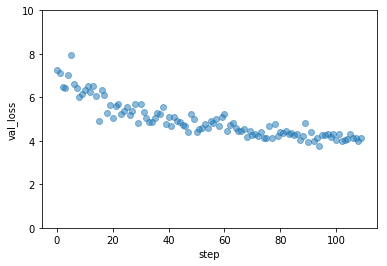

In [29]:
plt.scatter(np.arange(0, cs.shape[0]), cs['val_loss'].values, alpha=0.5)
plt.ylabel("val_loss")
plt.xlabel("step")
plt.ylim(0,10)

(0, 0.5)

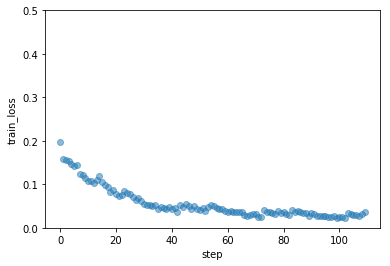

In [30]:
plt.scatter(np.arange(0, cs.shape[0]), cs['loss'].values, alpha=0.5)
plt.ylabel("train_loss")
plt.xlabel("step")
plt.ylim(0,0.5)

In [ ]:
model.save_weights('ResNet70.h5')

In [ ]:
with open("ResNet70.json", "w") as json_file:
    json_file.write(model.to_json())

In [30]:
from sklearn.metrics.pairwise import paired_euclidean_distances
from sklearn.metrics import mean_squared_error

In [31]:
preds = np.maximum(model.predict(X_test), 0)
test_resultsE = mean_squared_error(preds[:,0], y_test[:,0])

In [32]:
test_resultsE.mean()

0.017952209325700682

(-0.05, 0.05)

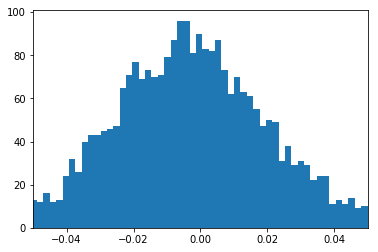

In [33]:
plt.hist((preds[:,0] - y_test[:,0])/y_test[:,0], bins=200)
plt.xlim((-0.05,0.05))

In [34]:
from tqdm import tqdm

In [35]:
root_data_path = '/mnt/iprovilkov/data_dir/0MeV_lpmt_hits.h5'

In [37]:
def test_sigmas(model, test_dir='/mnt/iprovilkov/data_dir/', test_column='E', MAXR=MAXR, use_spmt=True,
                time=False, recompute=False):
    sigmas = {}
    MSEs = {}
    predictions = {}
    CONST = 1.022
    for energy in tqdm(range(10)):
        try:
            if recompute:
                raise Exception("Recompute")
            if time:
                data_lpmt = np.load(test_dir + str(energy) + 'data_lpmt_time_YuXu.npy')
            else:
                data_lpmt = np.load(test_dir + str(energy) + 'data_lpmt_YuXu.npy')
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
        except: 
            print("Compute...")
            lpmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+ 'lpmt_hits.h5', mode='r') 
            spmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+'spmt_hits.h5', mode='r')
            lpmt_hits = lpmt_hits[lpmt_hits.isDN==False]
            spmt_hits = spmt_hits[spmt_hits.isDN==False]
            pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'lpmt_pos.csv') 
            spmt_pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'spmt_pos.csv') 
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
            if time:
                data_lpmt, event_to_id = get_data_2dprojection(lpmt_hits, 
                                    spmt_hits, 
                                    pos, 
                                    true_info,
                                    use_spmt=use_spmt,
                                    time='min')
                np.save(test_dir+str(energy)+'data_lpmt_time_YuXu', data_lpmt)
            else:
                data_lpmt, event_to_id = get_data_2dprojection(lpmt_hits, 
                                    spmt_hits, 
                                    pos, 
                                    true_info,
                                    use_spmt=use_spmt)
                np.save(test_dir+str(energy)+'data_lpmt_YuXu', data_lpmt)
        mask = (true_info.R<=MAXR)
        data_lpmt = data_lpmt[mask]
        true_info = true_info[mask]
        preds = np.maximum(model.predict(data_lpmt), 0)
        y_test = true_info[test_column]
        print(y_test.mean())
        predictions[energy] = preds
        MSEs[energy] = mean_squared_error(preds, y_test)
        # in percents
        sigmas[energy] = np.std(preds - y_test.mean()) / (energy + CONST)
    print("+")
    return sigmas, MSEs, predictions

In [38]:
sigmas, MSEs, predictions = test_sigmas(model, use_spmt=False, time=True, recompute=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Compute...
Make projection
Starting cycle...


 10%|█         | 1/10 [01:00<09:03, 60.36s/it]

0.5109988999999999
Compute...
Make projection
Starting cycle...


 20%|██        | 2/10 [02:13<08:33, 64.13s/it]

1.5109988697622994
Compute...
Make projection
Starting cycle...


 30%|███       | 3/10 [03:39<08:16, 70.87s/it]

2.5109990065502177
Compute...
Make projection
Starting cycle...


 40%|████      | 4/10 [05:21<08:00, 80.13s/it]

3.5109988987951803
Compute...
Make projection
Starting cycle...


 50%|█████     | 5/10 [07:17<07:33, 90.78s/it]

4.510998806956522
Compute...
Make projection
Starting cycle...


 60%|██████    | 6/10 [09:25<06:48, 102.13s/it]

5.510998686870312
Compute...
Make projection
Starting cycle...


 70%|███████   | 7/10 [11:45<05:40, 113.50s/it]

6.510998666593649
Compute...
Make projection
Starting cycle...


 80%|████████  | 8/10 [14:16<04:09, 124.51s/it]

7.510998798899285
Compute...
Make projection
Starting cycle...


 90%|█████████ | 9/10 [17:00<02:16, 136.50s/it]

8.510999212171052
Compute...
Make projection
Starting cycle...


100%|██████████| 10/10 [20:03<00:00, 150.57s/it]

9.510998837121212
+


In [41]:
sigmas, MSEs

({0: 0.0419280366013428,
  1: 0.030064885343335616,
  2: 0.024637122330959074,
  3: 0.025843863372243144,
  4: 0.02264239158064471,
  5: 0.021284497465179908,
  6: 0.02345127008199624,
  7: 0.019266551285722078,
  8: 0.019227727055153226,
  9: 0.018848748210422817},
 {0: 0.00785320471695341,
  1: 0.003705536978070747,
  2: 0.005739267643567559,
  3: 0.011141431965297056,
  4: 0.01380134887427723,
  5: 0.01658446326430096,
  6: 0.027651218129726443,
  7: 0.024080398235444826,
  8: 0.030120290175814593,
  9: 0.03744599026400079})

In [42]:
a = 2.8
b=0.59
c=0


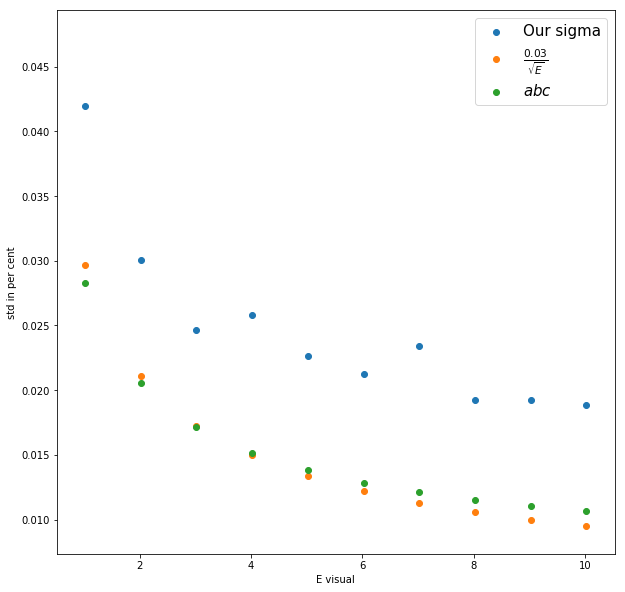

In [43]:
# Plot sigmas
Evis = np.array([en + 1.022  for en in range(10)])
Perc_sigmas = [sigmas[en] for en in range(10)]
perc_3_sqrt_E = [0.03 / np.sqrt(en) for en in Evis]
fig = plt.figure(figsize=(10,10))
plt.scatter(Evis, Perc_sigmas, label='Our sigma')
plt.scatter(Evis, perc_3_sqrt_E, label=r'$\frac{0.03}{\sqrt{E}}$')
plt.scatter(Evis, 0.01*np.sqrt((a/np.sqrt(Evis))**2 + b**2 + (c/Evis)**2), label=r'$abc$')
plt.ylabel("std in per cent")
plt.xlabel("E visual")
plt.legend(fontsize=15)